# Visualizing traveltime along a Line

This notebook is a continuation of the study I've been doing of public transit:

1. [Initial blogpost](https://arktekk.no/blogs/2025_entur_realtimedataset)
2. [The initial notebook](https://github.com/kaaveland/bus-eta/blob/main/EnturRealtimeEDA.ipynb)
3. [Webapp](https://kollektivkart.arktekk.no)

I've been wanting to find out how to produce good, interactive visualizations for an individual line. I want people to be able to go to the webapp and enter `RUT:Line:265` to see patterns in the travel time of their particular bus. This notebook is my exploration of that problem. I aim to first solve the problem very specifically, for one line, one day, then try to scale it up to all lines for one day, then to all lines for a month, by iteratively improving queries.

As preparation, I've prepared some data files. Arrival data, mostly the same schema as on [Real-Time](https://data.entur.no/domain/public-transport-data/product/realtime_siri_et/urn:li:container:1d391ef93913233c516cbadfb190dc65):

1. https://kaaveland-bus-eta-data.hel1.your-objectstorage.com/entur_realtime.parquet is a single day of real time data, specifically 2025-
2. https://kaaveland-bus-eta-data.hel1.your-objectstorage.com/entur_realtime_month.parquet is an entire month of real time data

Stop and quay data, for geolocation of stops and normalization on stop names.

1. https://kaaveland-bus-eta-data.hel1.your-objectstorage.com/quays.parquet one version of all quay stop points
2. https://kaaveland-bus-eta-data.hel1.your-objectstorage.com/stops.parquet one version of all stop points

Since I will retrieve this data over https in the notebook, it should run as-is on your machine, if you want to tinker and play along.

Let's do some imports and get started.

In [1]:
import numpy as np
import pandas as pd
import duckdb
import seaborn as sns
# Set up some styling for the visual stuff
sns.set_theme(
    style='whitegrid', rc={
        'figure.figsize': (12, 8),
        'figure.frameon': False,
        'legend.frameon': False
    }
)

s3_bucket = 'https://kaaveland-bus-eta-data.hel1.your-objectstorage.com'

db = duckdb.connect(':memory:')

%load_ext sql
%config SqlMagic.displaylimit=50
%sql db --alias duckdb

%sql create or replace table arrivals as from read_parquet('{{s3_bucket}}/entur_realtime.parquet');
%sql describe arrivals;

The 'toml' package isn't installed. To load settings from pyproject.toml or ~/.jupysql/config, install with: pip install toml

Running query in 'duckdb'

Running query in 'duckdb'

column_name,column_type,null,key,default,extra
recordedAtTime,TIMESTAMP WITH TIME ZONE,YES,None,None,None
lineRef,VARCHAR,YES,None,None,None
directionRef,VARCHAR,YES,None,None,None
serviceJourneyId,VARCHAR,YES,None,None,None
operatorRef,VARCHAR,YES,None,None,None
extraJourney,BOOLEAN,YES,None,None,None
journeyCancellation,BOOLEAN,YES,None,None,None
stopPointRef,VARCHAR,YES,None,None,None
sequenceNr,BIGINT,YES,None,None,None
originName,VARCHAR,YES,None,None,None


Understanding the data:

Each row in this table is a recording of some vehicle arriving at some stop. Here are some important columns:

1. `serviceJourneyId` is the ID of this particular journey. Each arrival at another stop by the vehicle on the same journey reuses this ID, but will have a bigger `sequenceNr`.
2. `lineRef` refers to which particular line that the journey takes plane on. There are variations within a line.
3. `directionRef` is one obvious way in which lines can vary. The line can be headed into town or out from town, for example.
4. `originName` and `destinationName` is another way in which lines can vary. I've found that these aren't always reliable, though:

In [2]:
%%sql
select
  (100 * mean(originName is null :: int)) :: int as missing_origin,
  (100 * mean(destinationName is null :: int)) :: int as missing_destination
from arrivals;

Running query in 'duckdb'

missing_origin,missing_destination
75,80


In fact, `originName` and `destinationName` are missing most of the time. That's okay, because we can find out by taking the first and last `stopPointRef` in each journey by `sequenceNr` to find out what they really are.

There are also some time stamp fields that are interesting:

- `aimedArrivalTime`, `arrivalTime` - the planned and actual arrival time for the journey to arrive at `stopPointRef`. The very first stop in each journey is missing these.
- `aimedDepartureTime`, `departureTime` - the planned and actual departure time for the journey to depart `stopPointRef`. The very last stop in each journey is missing these.

As a data quality thing, I'm interesting in finding out what the consequence of `journeyCancellation`, `stopCancellation` or `extraCall` are. Let's take a look at each of them in turn:

In [3]:
%%sql
select * from arrivals
where journeyCancellation
order by serviceJourneyId, sequenceNr
limit 10


Running query in 'duckdb'

recordedAtTime,lineRef,directionRef,serviceJourneyId,operatorRef,extraJourney,journeyCancellation,stopPointRef,sequenceNr,originName,destinationName,extraCall,stopCancellation,aimedArrivalTime,arrivalTime,aimedDepartureTime,departureTime,dataSource,dataSourceName,estimated
2025-04-20 07:26:51.383266+02:00,MOR:Line:1070,2,MOR:ServiceJourney:1070_709_9150000025468954,MOR:Operator:259,False,True,NSR:Quay:68112,1,None,None,False,False,2025-04-20 07:35:00+02:00,2025-04-20 07:35:00+02:00,2025-04-20 07:35:00+02:00,2025-04-20 07:35:00+02:00,MOR,FRAM,True
2025-04-20 07:26:51.383266+02:00,MOR:Line:1070,2,MOR:ServiceJourney:1070_709_9150000025468954,MOR:Operator:259,False,True,NSR:Quay:69465,2,None,None,False,False,2025-04-20 08:08:00+02:00,2025-04-20 08:08:00+02:00,None,None,MOR,FRAM,True
2025-04-20 08:21:24.005327+02:00,MOR:Line:1070,1,MOR:ServiceJourney:1070_712_9150000025465740,MOR:Operator:259,False,True,NSR:Quay:69465,1,None,None,False,False,2025-04-20 08:20:00+02:00,2025-04-20 08:20:00+02:00,2025-04-20 08:20:00+02:00,2025-04-20 08:20:00+02:00,MOR,FRAM,True
2025-04-20 08:21:24.005327+02:00,MOR:Line:1070,1,MOR:ServiceJourney:1070_712_9150000025465740,MOR:Operator:259,False,True,NSR:Quay:68112,2,None,None,False,False,2025-04-20 08:53:00+02:00,2025-04-20 08:53:00+02:00,None,None,MOR,FRAM,True
2025-04-20 06:13:58.035067+02:00,SKY:Line:1018,inbound,SKY:ServiceJourney:1018-182269-17571266,SKY:Operator:TORGH,False,True,NSR:Quay:100076,1,None,None,False,False,None,None,2025-04-20 05:40:00+02:00,2025-04-20 05:40:00+02:00,GCO,None,True
2025-04-20 06:13:58.035067+02:00,SKY:Line:1018,inbound,SKY:ServiceJourney:1018-182269-17571266,SKY:Operator:TORGH,False,True,NSR:Quay:99988,2,None,None,False,False,2025-04-20 06:25:00+02:00,2025-04-20 06:25:00+02:00,None,None,GCO,None,True
2025-04-20 06:13:58.035926+02:00,SKY:Line:1018,outbound,SKY:ServiceJourney:1018-182269-17571295,SKY:Operator:TORGH,False,True,NSR:Quay:99988,1,None,None,False,False,None,None,2025-04-20 06:30:00+02:00,2025-04-20 06:30:00+02:00,GCO,None,True
2025-04-20 06:13:58.035926+02:00,SKY:Line:1018,outbound,SKY:ServiceJourney:1018-182269-17571295,SKY:Operator:TORGH,False,True,NSR:Quay:100076,2,None,None,False,False,2025-04-20 07:15:00+02:00,2025-04-20 07:15:00+02:00,None,None,GCO,None,True
2025-04-20 16:50:16.101760+02:00,SOF:Line:3501_69,inbound,SOF:ServiceJourney:1045_204_1250_69,SOF:Operator:996,False,True,NSR:Quay:99715,1,None,None,False,False,None,None,2025-04-20 17:10:00+02:00,2025-04-20 17:10:00+02:00,GCO,None,True
2025-04-20 16:50:16.101760+02:00,SOF:Line:3501_69,inbound,SOF:ServiceJourney:1045_204_1250_69,SOF:Operator:996,False,True,NSR:Quay:64480,2,None,None,False,False,2025-04-20 17:30:00+02:00,2025-04-20 17:30:00+02:00,None,None,GCO,None,True


At first glance, it looks like if `journeyCancellation`, it means all subsequent stops are cancelled. Let's check if that intuition holds up by checking if we can find a counterexample:

In [4]:
%%sql
with cancelled as (
     from arrivals where journeyCancellation
)
from arrivals a join cancelled c
     on a.serviceJourneyId = c.serviceJourneyId
     and a.sequenceNr > c.sequenceNr
select a.lineRef, a.serviceJourneyId, c.arrivalTime as cancelledTime, a.arrivalTime, c.sequenceNr, a.sequenceNr, a.estimated;


Running query in 'duckdb'

lineRef,serviceJourneyId,cancelledTime,arrivalTime,sequenceNr,sequenceNr_1,estimated
SOF:Line:3501_69,SOF:ServiceJourney:1045_204_1250_69,None,2025-04-20 17:30:00+02:00,1,2,True
SKY:Line:1018,SKY:ServiceJourney:1018-182269-17571266,None,2025-04-20 06:25:00+02:00,1,2,True
MOR:Line:1070,MOR:ServiceJourney:1070_709_9150000025468954,2025-04-20 07:35:00+02:00,2025-04-20 08:08:00+02:00,1,2,True
VYG:Line:R31,VYG:ServiceJourney:43a911d5-f641-4bc1-942f-1c63af09ef71-222-2025-04-20-0,2025-04-20 15:19:00+02:00,2025-04-20 15:28:00+02:00,2,3,True
VYG:Line:R31,VYG:ServiceJourney:43a911d5-f641-4bc1-942f-1c63af09ef71-222-2025-04-20-0,2025-04-20 15:10:40+02:00,2025-04-20 15:19:00+02:00,1,2,True
VYG:Line:R31,VYG:ServiceJourney:43a911d5-f641-4bc1-942f-1c63af09ef71-222-2025-04-20-0,2025-04-20 15:10:40+02:00,2025-04-20 15:28:00+02:00,1,3,True
SKY:Line:1018,SKY:ServiceJourney:1018-182269-17571295,None,2025-04-20 07:15:00+02:00,1,2,True
MOR:Line:1070,MOR:ServiceJourney:1070_712_9150000025465740,2025-04-20 08:20:00+02:00,2025-04-20 08:53:00+02:00,1,2,True
SOF:Line:3501_69,SOF:ServiceJourney:1045_270_1247_69,None,2025-04-20 17:00:00+02:00,1,2,True


Right, so when `journeyCancellation` the rest of the stops are `estimated`. We should probably ignore all data that has `journeyCancellation` or `estimated`.

Let's try to see how `stopCancellation` works:

In [5]:
%%sql
from arrivals
select
    serviceJourneyId,
    journeyCancellation,
    sequenceNr,
    lag(sequenceNr) over w as last_seen,
    lead(sequenceNr) over w as next_seen,
    arrivalTime,
    lag(arrivalTime) over w as last_seen_time,
    lead(arrivalTime) over w as next_seen_time,
    lag(stopCancellation) over w as last_canceled,
    lead(stopCancellation) over w as next_canceled
where stopCancellation and not estimated
window w as (partition by (serviceJourneyId) order by sequenceNr)
qualify last_seen is not null or next_seen is not null
order by serviceJourneyId, sequenceNr
limit 20;

Running query in 'duckdb'

serviceJourneyId,journeyCancellation,sequenceNr,last_seen,next_seen,arrivalTime,last_seen_time,next_seen_time,last_canceled,next_canceled
ATB:ServiceJourney:70_240826121303111_7002,False,32,None,33,None,None,None,None,True
ATB:ServiceJourney:70_240826121303111_7002,False,33,32,34,None,None,None,True,True
ATB:ServiceJourney:70_240826121303111_7002,False,34,33,None,None,None,None,True,None
FLT:ServiceJourney:1-2614-3752-20250420,False,1,None,2,None,None,None,None,True
FLT:ServiceJourney:1-2614-3752-20250420,False,2,1,None,None,None,None,True,None
KOL:ServiceJourney:5200_250221104744502_5004,False,4,None,6,None,None,None,None,True
KOL:ServiceJourney:5200_250221104744502_5004,False,6,4,10,None,None,None,True,True
KOL:ServiceJourney:5200_250221104744502_5004,False,10,6,None,None,None,None,True,None
KOL:ServiceJourney:5200_250221104744529_5011,False,2,None,6,None,None,None,None,True
KOL:ServiceJourney:5200_250221104744529_5011,False,6,2,7,None,None,None,True,True


Right, this data looks sketchy. We should probably not include any registrations past a point where any arrival has `stopCancellation`.

In [6]:
%%sql
from arrivals
select *
where extraCall;

Running query in 'duckdb'

recordedAtTime,lineRef,directionRef,serviceJourneyId,operatorRef,extraJourney,journeyCancellation,stopPointRef,sequenceNr,originName,destinationName,extraCall,stopCancellation,aimedArrivalTime,arrivalTime,aimedDepartureTime,departureTime,dataSource,dataSourceName,estimated


There are no `extraCall` this day.

## Summary so far

We use only data where none of these are true:

- `stopCancellation`, `estimated`, `journeyCancellation`, `extraCall`

## Establishing normal schedules and routes

We've found that we can't use the existing `origin` and `destination` columns, but we can create our own. Let's check if we get sensible results.

In [7]:
%%sql

create or replace table routes as
from arrivals
select
    lineRef,
    directionRef,
    first(stopPointRef order by sequenceNr) as origin ,
    last(stopPointRef order by sequenceNr) as destination
group by lineRef, directionRef
having not (bool_or(extraCall) or bool_or(estimated) or bool_or(journeyCancellation) or bool_or(stopCancellation));

from routes
where lineRef = 'ATB:Line:2_10';

Running query in 'duckdb'

lineRef,directionRef,origin,destination
ATB:Line:2_10,Inbound,NSR:Quay:103580,NSR:Quay:73483
ATB:Line:2_10,Outbound,NSR:Quay:73482,NSR:Quay:103580


In [8]:
%%sql

from routes
where lineRef = 'ATB:Line:2_14';

Running query in 'duckdb'

lineRef,directionRef,origin,destination
ATB:Line:2_14,Outbound,NSR:Quay:75300,NSR:Quay:73036
ATB:Line:2_14,Inbound,NSR:Quay:73038,NSR:Quay:71982


In [9]:
%%sql
from routes
select
  lineRef,
  directionRef,
  count(*),
group by lineRef, directionRef
having count(*) > 1

Running query in 'duckdb'

lineRef,directionRef,count_star()


At first glance, it looks like we could probably use this method to set the origin and destination for each route correctly. Dare we also hope that each transit on a route with a direction visited the same stops in the same order?

In [10]:
%%sql

create or replace table stop_order as
from arrivals
select
    lineRef,
    directionRef,
    array_agg(stopPointRef order by sequenceNr) as stops
group by lineRef, directionRef
having not (bool_or(extraCall) or bool_or(estimated) or bool_or(journeyCancellation) or bool_or(stopCancellation));

from stop_order
select
    lineRef,
    directionRef,
    count(*)
group by lineRef, directionRef
having count(*) > 1;

Running query in 'duckdb'

lineRef,directionRef,count_star()


That feels almost magical, excellent data quality. Does doesn't feel like it would hold up if we were to use a whole month of data. Let's test it:

In [11]:
%%sql

create or replace table arrivals as from read_parquet('{{s3_bucket}}/entur_realtime_month.parquet');

create or replace table stop_order as
from arrivals
select
    lineRef,
    directionRef,
    array_agg(stopPointRef order by sequenceNr) as stops
group by lineRef, directionRef
having not (bool_or(extraCall) or bool_or(estimated) or bool_or(journeyCancellation) or bool_or(stopCancellation));

from stop_order
select
    lineRef,
    directionRef,
    count(*)
group by lineRef, directionRef
having count(*) > 1;

Running query in 'duckdb'

lineRef,directionRef,count_star()


In [12]:
%%sql
from arrivals select min(operatingDate) as from_date, max(operatingDate) as to_date

Running query in 'duckdb'

from_date,to_date
2025-03-01,2025-03-31


## Summary

Data quality for this particular month is excellent. We can get away with plotting the stops in the order that we observe them by `sequenceNr`. This makes me very happy. I wonder how many routes we saw across the whole month?

In [13]:
%sql select count(*) from stop_order

Running query in 'duckdb'

count_star()
1570


That's not too many. Data quality appears worryingly good, so I want to make some extra sanity checks. This seems unlikely to happen in the real world. I want to know how many journeys there were and how many our filter removes:

In [14]:
%%sql
with journeys as (
    from arrivals select distinct serviceJourneyId, operatingDate
) select count(*) from journeys;


Running query in 'duckdb'

count_star()
1790267


In [15]:
%%sql
with journeys as (
    from arrivals select serviceJourneyId, operatingDate
    group by serviceJourneyId, operatingDate
    having (bool_or(extraCall) or bool_or(estimated) or bool_or(journeyCancellation) or bool_or(stopCancellation))
) select count(*) from journeys;

Running query in 'duckdb'

count_star()
308389


We are removing quite a bit of data here, around one sixth. I think I'm fine with that. Let's check out what the reasons tend to be:

In [16]:
%%sql
with journeys as (
    from arrivals
    select
        serviceJourneyId,
        operatingDate,
        bool_or(extraCall) as extraCall,
        bool_or(estimated) as estimated,
        bool_or(journeyCancellation) as journeyCancellation,
        bool_or(stopCancellation) as stopCancellation
    group by serviceJourneyId, operatingDate
)
from journeys
select
    sum(extraCall :: int) as extraCall,
    sum(estimated :: int) as estimated,
    sum(journeyCancellation :: int) as journeyCancellation,
    sum(stopCancellation :: int) as stopCancellation

Running query in 'duckdb'

extraCall,estimated,journeyCancellation,stopCancellation
0,289162,5251,28962


We drop by far the most data by refusing to use `estimated` rows. I think that's fine, given that we saw `estimated` rows being produced after encountering `journeyCancellation`, and there weren't any `arrivalTime`s on those rows.

I'm starting to think I know what I need to know to produce reasonably good data for plots for lines. I'm thinking of a few use cases here:

### 1. What are delays like at different stop points in a route?

I imagine that at some time, let's say 08:00, some parts of the route have bigger delays than others. For someone casually looking up their bus line, that would probably be interesting. For a plot about this, we could slice the data into buckets by the hour of the day that the arrival happened and work out the delay by looking at the planned arrival time. We would produce 24 different plots with stop points on one axis, and time on the other axis. It would make the most sense to be to plot quantiles for the time, as it is so fast to calculate, can be stored compactly and is easy to draw. It may also be interesting to look at some plots with boxplots or confidence intervals.

### 2. Comparing delays on a route across dates

This is a little bit like the idea above, but more focused on finding out the effects on some change in traffic that happened at a known time. I think I want to crunch the numbers by month. That way, I could let a user view a side-by-side plot of the same route for october 2024 and october 2025 to figure out if the delay got worse. It may be interesting to use this kind of view to figure out if public transportation got better when EVs were no longer allowed to use the bus lane, for example. This is all about comparing rush hour (for example 08:XX) on different dates.

## 3. Comparing delays on a route across different hours

This would be all about comparing delays at 07:XX and 08:XX, not across different dates. This too could probably be built from the same pieces as 1. Strictly speaking, perhaps 2. and 3. are the same idea, we'd just need to let the user select both.

For both of the last two ideas, we can choose to either attempt to let the user view plots side-by-side, or we could attempt to subtract one result set from another to focus on the difference. The attractive part of the last method is that we could gain a way to identify routes where there have been big changes automatically, to help people identify which routes that are worth studying. Maybe it's worth looking into both ideas.

## Facts

1. We have some filters for journeys we must remove, it will be the first part of our pipeline.
2. For the remainder, we know that a route is uniquely identified by the `lineRef` and a `directionRef`, at least for the month we are currently studying.

It should be fairly easy to aggregate everything all at once. Let's try:

In [17]:
%%sql
create or replace table by_hour as
with selected_journeys as (
    from arrivals select serviceJourneyId, operatingDate
    group by serviceJourneyId, operatingDate
    having not (bool_or(extraCall) or bool_or(estimated) or bool_or(journeyCancellation) or bool_or(stopCancellation))
), times as (
    from arrivals a join selected_journeys using(serviceJourneyId, operatingDate)
    select
        -- group key
        lineRef,
        directionRef,
        stopPointRef,
        sequenceNr,
        extract(hour from coalesce(arrivalTime, departureTime)) as hour,
        -- aggregate this in next query
        extract(epoch from coalesce(arrivalTime, departureTime) - coalesce(aimedArrivalTime, aimedDepartureTime)) as delay_seconds
)
from times t
select
    t.* exclude (delay_seconds), -- group by
    quantile_disc(delay_seconds, .1) as first_decile,
    quantile_disc(delay_seconds, .25) as first_quartile,
    quantile_disc(delay_seconds, .5) as median,
    quantile_disc(delay_seconds, .75) as last_quartile,
    quantile_disc(delay_seconds, .9) as last_decile,
    count(*) as count
group by all;

Running query in 'duckdb'

Count
1373124


That's a biggish table. Let's check if anything makes sense by looking up a line I know well for one hour and plotting it. There should only be one row for each stop.

In [18]:
df = db.sql("select * from by_hour where lineRef = 'ATB:Line:2_14' and hour = 8").df()

df.head()

,lineRef,directionRef,stopPointRef,sequenceNr,hour,first_decile,first_quartile,median,last_quartile,last_decile,count
0,ATB:Line:2_14,Inbound,NSR:Quay:71959,19,8,10.0,29.0,67.0,87.0,107.0,21
1,ATB:Line:2_14,Inbound,NSR:Quay:72785,20,8,16.0,37.0,77.0,96.0,120.0,21
2,ATB:Line:2_14,Outbound,NSR:Quay:73261,7,8,38.0,91.0,133.0,187.0,271.0,82
3,ATB:Line:2_14,Outbound,NSR:Quay:102732,24,8,-63.0,-18.0,19.0,103.0,206.0,26
4,ATB:Line:2_14,Inbound,NSR:Quay:72033,11,8,-58.0,-4.0,7.0,69.0,102.0,10


We should be able to plot this. For it to work nicely with `seaborn`, we will need to shape the dataframe a little differently. This dataframe is "wide", but seaborn works best with "long" or "tall" dataframes. We can easily use `df.melt` to do this:

In [19]:
d = df.drop(
    columns=['lineRef', 'hour', 'stopPointRef']
).melt(
    id_vars=['directionRef', 'sequenceNr'],
    var_name='quantity',
    value_name='delay'
).sort_values(by=['directionRef', 'sequenceNr'])
d.head()

,directionRef,sequenceNr,quantity,delay
31,Inbound,1,first_decile,18.0
158,Inbound,1,first_quartile,26.0
285,Inbound,1,median,64.0
412,Inbound,1,last_quartile,92.0
539,Inbound,1,last_decile,130.0


We should be able to plot this, let's give it a shot:

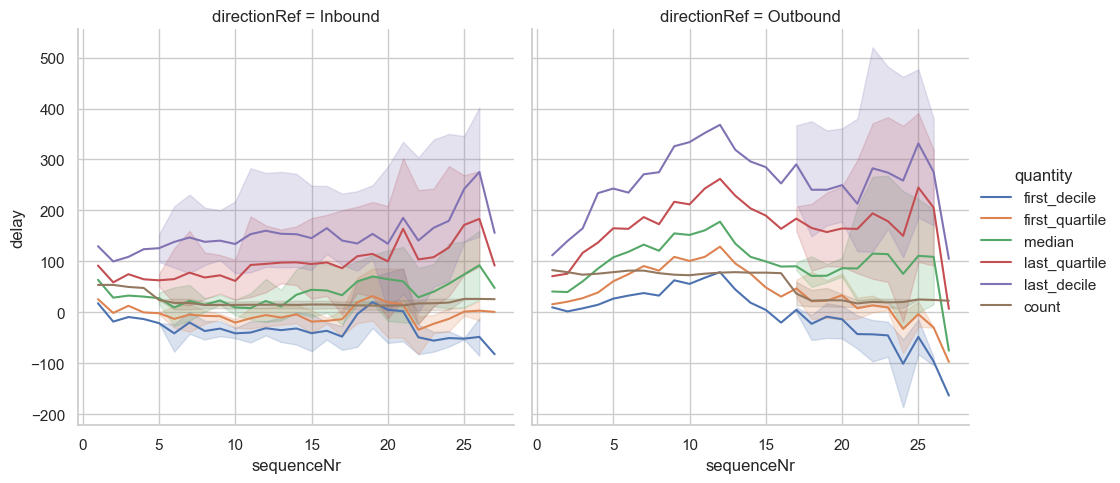

In [20]:
sns.relplot(
    d,
    x='sequenceNr',
    y='delay',
    hue='quantity',
    col='directionRef',
    kind='line'
);

Oh no, that didn't go well at all. We were not supposed to get confidence intervals here. It means that some `sequenceNr` have multiple registrations. This can only mean that our aggregation is imperfect. I thought we had established that the stop order by sequence nr was the same always, but that must not be the case (I thought this was suspicious in the first place). Let's dig into that and see what happened.

In [21]:
df.loc[
    (df.directionRef == 'Outbound') & (df.sequenceNr >= 20)
].sort_values(by=['sequenceNr', 'stopPointRef'])

,lineRef,directionRef,stopPointRef,sequenceNr,hour,first_decile,first_quartile,median,last_quartile,last_decile,count
77,ATB:Line:2_14,Outbound,NSR:Quay:73791,20,8,-2.0,39.0,70.0,90.0,178.0,11
12,ATB:Line:2_14,Outbound,NSR:Quay:75404,20,8,-51.0,-14.0,83.0,247.0,361.0,48
21,ATB:Line:2_14,Outbound,NSR:Quay:75657,20,8,13.0,76.0,107.0,157.0,210.0,12
69,ATB:Line:2_14,Outbound,NSR:Quay:102732,21,8,-63.0,14.0,33.0,86.0,120.0,10
107,ATB:Line:2_14,Outbound,NSR:Quay:71577,21,8,-41.0,-11.0,31.0,131.0,146.0,22
30,ATB:Line:2_14,Outbound,NSR:Quay:73036,21,8,-79.0,-13.0,18.0,68.0,120.0,12
116,ATB:Line:2_14,Outbound,NSR:Quay:74276,21,8,13.0,43.0,263.0,370.0,467.0,27
6,ATB:Line:2_14,Outbound,NSR:Quay:109990,22,8,-18.0,33.0,266.0,371.0,520.0,27
58,ATB:Line:2_14,Outbound,NSR:Quay:71365,22,8,-96.0,0.0,23.0,66.0,119.0,10
52,ATB:Line:2_14,Outbound,NSR:Quay:75600,22,8,-15.0,8.0,57.0,146.0,209.0,25


Exactly what I feared, stop nr 20 can be one of several different variants. Why did this go wrong? Clearly our `stop_order` table is wrong:

In [22]:
%%sql
from stop_order
select *
where lineRef = 'ATB:Line:2_14' and directionRef = 'Outbound'

Running query in 'duckdb'

lineRef,directionRef,stops


I have a sinking feeling that I know why. Let's review the SQL:
```sql
create or replace table stop_order as
from arrivals
select
    lineRef,
    directionRef,
    array_agg(stopPointRef order by sequenceNr) as stops
group by lineRef, directionRef
having not (bool_or(extraCall) or bool_or(estimated) or bool_or(journeyCancellation) or bool_or(stopCancellation));
```
This does the wrong thing _entirely_. It calculates the stop orders for only the `lineRef`, `directionRef` pairs that never had any journeys with cancellations or estimations. We need to do this calculation differently, more like how we approached the aggregation above. First, we make a list of all the journeys we want to keep, then join those with the `arrivals` to do the aggregation. I'm certain I made the same error when looking up `origin` and `destination` pairs, and I should have caught it already then. Oh well. This time, let's make a table of the journeys we want to use.

In [23]:
%%sql
create or replace table selected_journeys as
from arrivals select serviceJourneyId, operatingDate
group by serviceJourneyId, operatingDate
having not (bool_or(extraCall) or bool_or(estimated) or bool_or(journeyCancellation) or bool_or(stopCancellation));

create or replace table origins as
with observed as (
    from selected_journeys join arrivals using(serviceJourneyId, operatingDate)
    select
        lineRef,
        directionRef,
        serviceJourneyId,
        operatingDate,
        first(stopPointRef order by sequenceNr) as origin,
        last(stopPointRef order by sequenceNr) as destination
    group by all
)
from observed
select distinct
    lineRef,
    directionRef,
    origin,
    destination;

create or replace table stop_order as
with observed as (
    from selected_journeys join arrivals using(serviceJourneyId, operatingDate)
    select
        lineRef,
        directionRef,
        serviceJourneyId,
        operatingDate,
        array_agg(stopPointRef order by sequenceNr) as stops
    group by all
)
from observed
select distinct
    lineRef,
    directionRef,
    stops;

Running query in 'duckdb'

Count
21185


This time, I'm much more confident it is correct. Let us check how many variants of the 'ATB:Line:2_14' routes we spot now:

In [24]:
%%sql
from origins
select *
where lineRef = 'ATB:Line:2_14';

Running query in 'duckdb'

lineRef,directionRef,origin,destination
ATB:Line:2_14,Outbound,NSR:Quay:75300,NSR:Quay:73036
ATB:Line:2_14,Inbound,NSR:Quay:73038,NSR:Quay:71982


Still only one destination and origin in each direction. How about stops?

In [25]:
%%sql
from stop_order
select lineRef, directionRef, array_length(stops) as len
where lineRef = 'ATB:Line:2_14';

Running query in 'duckdb'

lineRef,directionRef,len
ATB:Line:2_14,Outbound,21
ATB:Line:2_14,Inbound,26
ATB:Line:2_14,Inbound,21
ATB:Line:2_14,Inbound,24
ATB:Line:2_14,Inbound,27
ATB:Line:2_14,Outbound,26
ATB:Line:2_14,Outbound,24
ATB:Line:2_14,Outbound,27


That means there are quite a lot of different variations. I suppose some of that could we weekend routes? Let's check if we get fewer by picking only weekdays:

In [26]:
%%sql
with observed as (
    from selected_journeys join arrivals using(serviceJourneyId, operatingDate)
    select
        lineRef,
        directionRef,
        serviceJourneyId,
        operatingDate,
        array_agg(stopPointRef order by sequenceNr) as stops
    where extract(weekday from operatingDate) not in (0, 6) and lineRef = 'ATB:Line:2_14'
    group by all
), routes as (
    from observed
    select distinct
        lineRef,
        directionRef,
        stops
) from routes select lineRef, directionRef, array_length(stops);

Running query in 'duckdb'

lineRef,directionRef,array_length(stops)
ATB:Line:2_14,Outbound,21
ATB:Line:2_14,Outbound,26
ATB:Line:2_14,Inbound,27
ATB:Line:2_14,Outbound,24
ATB:Line:2_14,Inbound,21
ATB:Line:2_14,Inbound,24
ATB:Line:2_14,Inbound,26
ATB:Line:2_14,Outbound,27


Actually, let's look up the [schedule](https://www.atb.no/getfile.php/13117915-1742208109/Rutetabeller/24-25_by/AtB_linje14%20avvik%20fra%2024.03.25.pdf).

From here I can see something I think is interesting and fascinating. It looks like some buses skip some segments. That's fine, we can work with that. What we will need to do is to establish a canonical ordering of the stops, then plot that instead of `sequenceNr` on the `X` axis. For now, let's work on the assumption that no lineRef/directionRef pair visits the same stop point twice within one journey. If that is the case, we can place the stop at its maximally observed `sequenceNr` for the lineRef/directionRef combination. Then we can check whether that still causes some duplicates by investigating whether we have duplicated `stopPointRef` with the same canonical `sequenceNr`.

In [27]:
%%sql
create or replace table canonical_ordering as
from selected_journeys join arrivals using(serviceJourneyId, operatingDate)
select
    lineRef,
    directionRef,
    stopPointRef,
    max(sequenceNr) as scheduleNr
group by lineRef, directionRef, stopPointRef;

Running query in 'duckdb'

Count
211065


If this worked, we should see a monotonically increasing `scheduleNr` for the bus we're looking at right now, that's fast to check:

In [28]:
%%sql
from canonical_ordering
select
    lineRef,
    directionRef,
    stopPointRef,
    scheduleNr
where lineRef = 'ATB:Line:2_14' and directionRef = 'Outbound'
order by lineRef, directionRef, scheduleNr

Running query in 'duckdb'

lineRef,directionRef,stopPointRef,scheduleNr
ATB:Line:2_14,Outbound,NSR:Quay:75300,1
ATB:Line:2_14,Outbound,NSR:Quay:71981,2
ATB:Line:2_14,Outbound,NSR:Quay:73420,3
ATB:Line:2_14,Outbound,NSR:Quay:73414,4
ATB:Line:2_14,Outbound,NSR:Quay:74952,5
ATB:Line:2_14,Outbound,NSR:Quay:102730,6
ATB:Line:2_14,Outbound,NSR:Quay:73261,7
ATB:Line:2_14,Outbound,NSR:Quay:72402,8
ATB:Line:2_14,Outbound,NSR:Quay:72787,9
ATB:Line:2_14,Outbound,NSR:Quay:71957,10


Perfect, that fixes this line! Let's check if there are any that are still broken:

In [29]:
%%sql
with broken as (
from canonical_ordering
select
    lineRef,
    directionRef,
    scheduleNr,
    count(*)
group by all
having count(*) > 1
) select count(*) from (from broken select distinct lineRef, directionRef);

Running query in 'duckdb'

count_star()
2941


We're still having problems with 2941 combinations of lineRef and directionRef.

In [30]:
%%sql
select count(*)
from (select distinct lineRef, directionRef from arrivals);

Running query in 'duckdb'

count_star()
7052


That's almost half the combinations we've seen. Hrm.

## Time for a break

I have to sleep on this to come up with some new ideas. Fundamentally, I only really need the order because I want to place the stops in the semantically correct order along an axis, I can disambiguate them perfectly by using their name. So we could easily just also use the `stopPointRef` as an input to the canonical ordering. But it would be jarring for a person to see "their stops" in semantically the wrong order, so I'd like to fix this. Maybe I could use the maximally observed scheduled time since departure at the origin to disambiguate better?

Since this is a displeasing place to stop, let's join our aggregation from earlier with the canonical ordering that works for ATB:Line:2_14 so we get to see how the plots come out:

In [31]:
%%sql
create or replace table by_hour as
with selected_journeys as (
    from arrivals select serviceJourneyId, operatingDate
    group by serviceJourneyId, operatingDate
    having not (bool_or(extraCall) or bool_or(estimated) or bool_or(journeyCancellation) or bool_or(stopCancellation))
), times as (
    from arrivals a join selected_journeys using(serviceJourneyId, operatingDate)
        join canonical_ordering using(lineRef, directionRef, stopPointRef)
    select
        -- group key
        lineRef,
        directionRef,
        scheduleNr,
        extract(hour from coalesce(arrivalTime, departureTime)) as hour,
        -- aggregate this in next query
        extract(epoch from coalesce(arrivalTime, departureTime) - coalesce(aimedArrivalTime, aimedDepartureTime)) as delay_seconds
    where extract(weekday from operatingDate) not in (0, 6)
)
from times t
select
    t.* exclude (delay_seconds), -- group by
    quantile_disc(delay_seconds, .1) as first_decile,
    quantile_disc(delay_seconds, .25) as first_quartile,
    quantile_disc(delay_seconds, .5) as median,
    quantile_disc(delay_seconds, .75) as last_quartile,
    quantile_disc(delay_seconds, .9) as last_decile,
    count(*) as count
group by all;

Running query in 'duckdb'

Count
988343


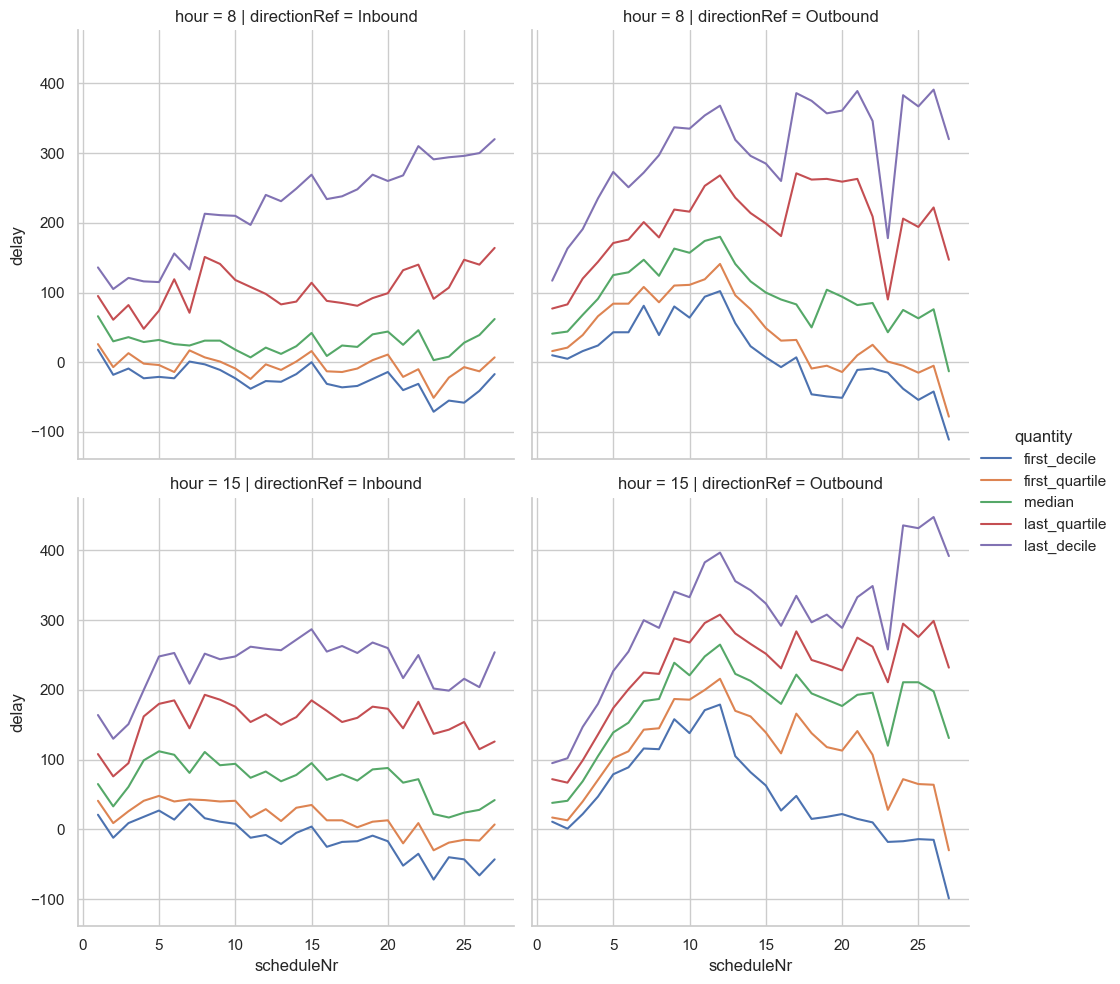

In [32]:
d = db.sql("select * from by_hour where lineRef = 'ATB:Line:2_14' and hour in (8, 15);").df().drop(
    columns=['lineRef', 'count']
).melt(
    id_vars=['directionRef', 'scheduleNr', 'hour'],
    var_name='quantity',
    value_name='delay'
)

sns.relplot(
    d,
    x='scheduleNr',
    y='delay',
    hue='quantity',
    col='directionRef',
    row='hour',
    kind='line'
);

This is progress, at least. It's fascinating to see how similar the morning and afternoon delay shapes are for this particular bus. I think this visualization can be done pretty well!